<a href="https://colab.research.google.com/github/Shahbaz894/agenticAi/blob/main/supervisor_agent.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [146]:

from typing import Annotated
from typing import Literal
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.tools import tool
from langchain_experimental.utilities import PythonREPL
from typing_extensions import TypedDict
from langgraph.graph import MessagesState, END,StateGraph, START
from langgraph.types import Command
from langchain_core.messages import HumanMessage
from langgraph.prebuilt import create_react_agent

In [147]:
# !pip install langgraph

In [148]:
# !pip install langchain-experimental


In [149]:
# !pip install langchain-community


In [150]:
# !pip install langchain_groq

In [151]:
# !!pip install -U langchain-community langchain-experimental tavily-python


In [152]:
from dotenv import load_dotenv

In [153]:
load_dotenv

<function dotenv.main.load_dotenv(dotenv_path: Union[str, ForwardRef('os.PathLike[str]'), NoneType] = None, stream: Optional[IO[str]] = None, verbose: bool = False, override: bool = False, interpolate: bool = True, encoding: Optional[str] = 'utf-8') -> bool>

In [154]:
from google.colab import userdata
api_key=userdata.get('GROQ_API_KEY')

In [155]:

from google.colab import userdata
tavily_api_key=userdata.get('TAVILY_API_KEY')

In [157]:
from langchain_groq import ChatGroq

In [158]:
groq_model=ChatGroq(model="deepseek-r1-distill-llama-70b",api_key=api_key)

In [159]:
response=groq_model.invoke('hi')

In [160]:
def clean_text(text):
  import re
  clean_text=re.sub(r"<think>.*?</think>\s*", "", text, flags=re.DOTALL)
  return clean_text

In [161]:
clean_text(response.content)

'Hello! How can I assist you today? 😊'

In [162]:
tavily_tool=TavilySearchResults(tavily_api_key=tavily_api_key)

In [163]:
res=tavily_tool.invoke('what is the gdp of pakistan')

In [164]:
res[-1]

{'title': 'Gross domestic product (GDP) 2024 - Pakistan - Statista',
 'url': 'https://www.statista.com/statistics/383739/gross-domestic-product-gdp-in-pakistan/',
 'content': 'In total, the GDP amounted to 374.6 billion U.S. dollars in 2024. The gross domestic product at current prices is defined based upon the GDP in national',
 'score': 0.8399576}

In [165]:
code="""
x=12
y=x^2
print(y)
"""

In [166]:
repl=PythonREPL()

In [167]:
result=repl.run(code)

In [168]:
result

'14\n'

In [169]:
@tool
def python_repl_tool(
    code:Annotated[str,"The python code to execute to generate your chart"],

):
  """ Use this to execute python code and do math.if you want to see the output of a value,
  you should print it with out prunt(...). this is visible to the user"""
  try:
    results=repl.run(code)
  except BaseException as e:
    return f"Failed to execute Error:{repr(e)}"
  result_str = f"Successfully executed:\n\`\`\`python\n{code}\n\`\`\`\nStdout: {result}"
  return result_str

In [170]:
print(python_repl_tool.invoke(code))

Successfully executed:
\`\`\`python

x=12
y=x^2
print(y)

\`\`\`
Stdout: 14



In [171]:

members=["researcher","coder"]

In [172]:
options=members+['FINISH']

In [173]:
options

['researcher', 'coder', 'FINISH']

In [174]:
class Router(TypedDict):
  """Worker to route to next.if no workers needed,route to FINISH
  """
  next:Literal['researcher', 'coder', 'FINISH']

In [175]:
class State(MessagesState):
  next:str

In [176]:
system_prompt=f"""
Yor are a supervisoer ,tasked with managing a converstaion between the following workers:{members}.
Given the following user request,respond with worker to act next.
Each worker will perform a task and respond with thier results and status.
When finished ,repond with FINISH.
"""

In [177]:
[{'role':'system','content':system_prompt}]

[{'role': 'system',
  'content': "\nYor are a supervisoer ,tasked with managing a converstaion between the following workers:['researcher', 'coder'].\nGiven the following user request,respond with worker to act next.\nEach worker will perform a task and respond with thier results and status.\nWhen finished ,repond with FINISH.\n"}]

In [178]:
state={'next':['hi']}

In [179]:
state['next']

['hi']

In [180]:
[{'role':'system','content':system_prompt}]+ state['next']

[{'role': 'system',
  'content': "\nYor are a supervisoer ,tasked with managing a converstaion between the following workers:['researcher', 'coder'].\nGiven the following user request,respond with worker to act next.\nEach worker will perform a task and respond with thier results and status.\nWhen finished ,repond with FINISH.\n"},
 'hi']

In [181]:

def supervisor_node(state: State) -> Command[Literal["researcher", "coder", "__end__"]]:

    messages = [{"role": "system", "content": system_prompt},] + state["messages"]

    response = groq_model.with_structured_output(Router).invoke(messages)

    goto = response["next"]

    print("below my goto**********************************")

    print(goto)

    if goto == "FINISH":
        goto = END

    return Command(goto=goto, update={"next": goto})



In [182]:

def research_node(state: State) -> Command[Literal["supervisor"]]:

    research_agent = create_react_agent(groq_model, tools=[tavily_tool], prompt="You are a researcher. DO NOT do any math.")

    result = research_agent.invoke(state)

    return Command(
        update={
            "messages": [
                HumanMessage(content=result["messages"][-1].content, name="researcher")
            ]
        },
        goto="supervisor",
    )

In [183]:
def code_node(state:State)->Command[Literal['supervisor']]:
  code_agent=create_react_agent(groq_model,tools=[python_repl_tool])
  result=code_agent.invoke(state)
  return Command(
      update={
          'messages':[HumanMessage(
              content=result['messages'][-1].content,name=['coder']
          )]
      },
      goto='supervisor'
  )

In [184]:
graph=StateGraph(State)

In [185]:
graph.add_node('supervisor',supervisor_node)

In [186]:
graph.add_node('researcher',research_node)

In [187]:
graph.add_node('coder',code_node)

In [188]:
graph.add_edge(START,'supervisor')

In [189]:
app=graph.compile()

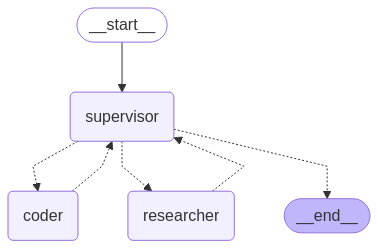

In [190]:

from IPython.display import display, Image

display(Image(app.get_graph().draw_mermaid_png()))

In [191]:
app.invoke({"messages": [("user", "What's the square root of 42?")]}, subgraphs=True)

below my goto**********************************
researcher
below my goto**********************************
researcher
below my goto**********************************
researcher
below my goto**********************************
researcher
below my goto**********************************
researcher
below my goto**********************************
FINISH


((),
 {'messages': [HumanMessage(content="What's the square root of 42?", additional_kwargs={}, response_metadata={}, id='d0cbb1c9-e9e0-4216-aa2a-23dd5fa49cd7'),
   HumanMessage(content='The square root of 42 is approximately 6.4807. \n\nStep-by-Step Explanation:\n\n1. Recognize that the square root of 42 lies between 6 and 7 since 6² = 36 and 7² = 49.\n\n2. Estimate by testing 6.5: 6.5² = 42.25, which is slightly above 42.\n\n3. Refine the estimate by testing 6.4: 6.4² = 40.96, which is slightly below 42.\n\n4. Further refine by testing 6.45: 6.45² ≈ 41.6025, still below 42.\n\n5. Test 6.48: 6.48² ≈ 41.9904, very close to 42.\n\n6. Conclude that the exact square root is irrational and approximate it as 6.4807.', additional_kwargs={}, response_metadata={}, name='researcher', id='37debf57-d73b-4f99-a3df-0d7916d18421'),
   HumanMessage(content='The square root of 42 is approximately 6.4807.', additional_kwargs={}, response_metadata={}, name='researcher', id='a13f2958-ca29-4a36-830c-99c7a